In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format",lambda x: '%.5f' % x)

df_ = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011")
df_.head()

In [4]:
df = df_.copy()

In [5]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10000,12680.00000,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15000,12680.00000,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15000,12680.00000,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95000,12680.00000,France
541909,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00000,12680.00000,France


In [6]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C",na=False)]
df = df[df["Quantity"]>0]
df = df[df["Price"]>0]
def find_limits(df,variable):
    q1 = df[variable].quantile(0.01)
    q3 = df[variable].quantile(0.99)
    iqr = q3 - q1
    upper_limit = q3 + 1.5*iqr
    lower_limit = q1 - 1.5*iqr
    return lower_limit, upper_limit

In [7]:
lower_limit, upper_limit = find_limits(df,"Quantity")
lower_limit, upper_limit
df["Quantity"].clip(upper=upper_limit,inplace=True)

In [8]:
lower_limit, upper_limit = find_limits(df,"Price")
lower_limit, upper_limit
df["Price"].clip(upper=upper_limit,inplace=True)

In [9]:
df["total_price"] = df["Quantity"] * df["Price"]


In [10]:
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data as summary

In [52]:
mf=summary(df,"Customer ID","InvoiceDate","total_price",
        observation_period_end="2011-12-10",
        freq="W")
mf

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.00000,0.00000,0.00000,46.00000,0.00000
12347.00000,6.00000,52.00000,52.00000,599.70167
12348.00000,3.00000,40.00000,51.00000,298.54000
12349.00000,0.00000,0.00000,2.00000,0.00000
12350.00000,0.00000,0.00000,44.00000,0.00000
...,...,...,...,...
18280.00000,0.00000,0.00000,39.00000,0.00000
18281.00000,0.00000,0.00000,26.00000,0.00000
18282.00000,1.00000,17.00000,18.00000,77.84000


In [40]:
monetary=df.groupby("Customer ID")["total_price"].sum()
monetary

Customer ID
12346.00000    310.44000
12347.00000   4310.00000
12348.00000   1770.78000
12349.00000   1491.72000
12350.00000    331.46000
                 ...    
18280.00000    180.60000
18281.00000     80.82000
18282.00000    178.05000
18283.00000   2094.88000
18287.00000   1837.28000
Name: total_price, Length: 4338, dtype: float64

In [41]:
mf=pd.merge(mf,monetary,left_index=True,right_index=True)
mf.rename(columns={"total_price":"monetary"},inplace=True)

In [42]:
mf

,frequency,recency,T,monetary
Customer ID,,,,
12346.00000,0.00000,0.00000,46.00000,310.44000
12347.00000,6.00000,52.00000,52.00000,4310.00000
12348.00000,3.00000,40.00000,51.00000,1770.78000
12349.00000,0.00000,0.00000,2.00000,1491.72000
12350.00000,0.00000,0.00000,44.00000,331.46000
...,...,...,...,...
18280.00000,0.00000,0.00000,39.00000,180.60000
18281.00000,0.00000,0.00000,26.00000,80.82000
18282.00000,1.00000,17.00000,18.00000,178.05000


In [24]:
mf

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.00000,0.00000,0.00000,46.00000,0.00000
12347.00000,6.00000,52.00000,52.00000,599.70167
12348.00000,3.00000,40.00000,51.00000,298.54000
12349.00000,0.00000,0.00000,2.00000,0.00000
12350.00000,0.00000,0.00000,44.00000,0.00000
...,...,...,...,...
18280.00000,0.00000,0.00000,39.00000,0.00000
18281.00000,0.00000,0.00000,26.00000,0.00000
18282.00000,1.00000,17.00000,18.00000,77.84000


In [43]:
mf["monetary"] = mf["monetary"] / (mf["frequency"]+1)

In [53]:
mf

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.00000,0.00000,0.00000,46.00000,0.00000
12347.00000,6.00000,52.00000,52.00000,599.70167
12348.00000,3.00000,40.00000,51.00000,298.54000
12349.00000,0.00000,0.00000,2.00000,0.00000
12350.00000,0.00000,0.00000,44.00000,0.00000
...,...,...,...,...
18280.00000,0.00000,0.00000,39.00000,0.00000
18281.00000,0.00000,0.00000,26.00000,0.00000
18282.00000,1.00000,17.00000,18.00000,77.84000


In [54]:
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(mf["frequency"],
        mf["recency"],
        mf["T"])

<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 0.00, alpha: 7.78, b: 0.00, r: 0.62>

In [55]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,mf["frequency"],
                                                            mf["recency"],
                                                            mf["T"]).sort_values(ascending =False).head(10)

Customer ID
14606.00000   0.86569
17841.00000   0.84924
14527.00000   0.81634
15311.00000   0.79989
14911.00000   0.78343
12748.00000   0.75053
12971.00000   0.75053
13089.00000   0.70117
15039.00000   0.69618
16422.00000   0.68472
dtype: float64

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

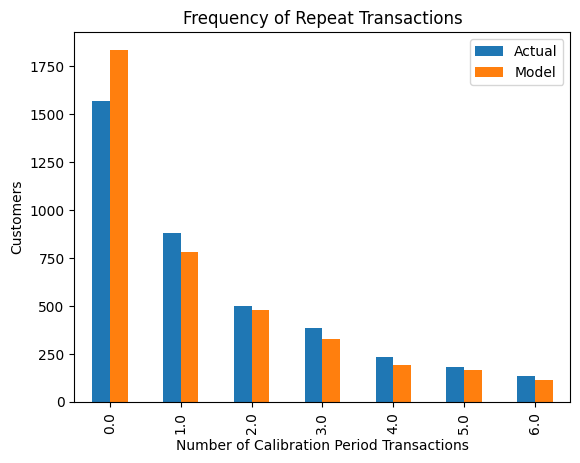

In [56]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(mf["frequency"],
        mf["recency"],
        mf["T"])
plot_period_transactions(bgf)

In [57]:
reurning= mf[mf["frequency"]>0]

In [58]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(reurning["frequency"],reurning["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2772 subjects, p: 3.77, q: 0.33, v: 3.65>

In [61]:
cltv = ggf.customer_lifetime_value(bgf,
                                   reurning["frequency"],
                                   reurning["recency"],
                                   reurning["T"],
                                   reurning["monetary_value"],
                                   time=3, #3 aylık
                                   freq="W", # T nin frekans bilgisi,
                                   discount_rate=0.01)

In [62]:
cltv.sort_values(ascending=False).head(10)

Customer ID
14646.00000   58536.01313
18102.00000   47777.01027
14096.00000   33291.30043
14911.00000   29241.70541
17450.00000   28934.87319
12415.00000   27579.67013
14156.00000   24948.63404
17511.00000   19339.15056
16684.00000   13641.00149
13694.00000   13627.79018
Name: clv, dtype: float64

In [93]:
cltv.sort_values(ascending=False).head(10)

Customer ID
14646.00000   58471.49082
18102.00000   49037.75613
14096.00000   31143.85255
14911.00000   29107.71070
17450.00000   27889.95231
12415.00000   27158.74528
14156.00000   24172.80199
17511.00000   18976.07213
13694.00000   13318.48968
16684.00000   13267.09758
Name: clv, dtype: float64

In [94]:
14646.00000	55741.08447
18102.00000	47412.58011
14096.00000	29061.66139
12415.00000	27685.10001
14911.00000	27377.41152
17450.00000	27166.06434
14156.00000	23424.40318
17511.00000	18986.61234
16684.00000	13440.41309
13694.00000	12966.13470

58471.4908150719